In [ ]:
!pip install stockstats
# !pip install git+git://github.com/peerchemist/finta.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import stockstats 
# from finta import TA

# Stockstats
Обертка над pandas DataFrame - StockDataFrame

Считается, что данные индексированы датой и содержат столбцы: <br>
- date: время записи, опционально.
- close: цена закрытия периода
- high: самая высокая цена за период
- low: самая низкая цена за период
- volume: объем торгов за период

Статистики - колонки в StockDataFrame. Просчитываются и добавляются в таблицу после их первого вызова.
- `change` (разница в процентах между соседними периодами цен закрытия)
- `<column>_delta` или `<column>_<window_size>_d`
- `log-ret` (log return = ln( close / last close)
- `<column>_<i>,<j>_min` и `<column>_<i>,<j>_max`, `<column>_<i>~0_min` - от i до нынешней позиции
- `middle` = (low + high + close) / 3
- `<column>_<window>_smma` - сглаженное скользящее среднее

In [ ]:
data = pd.read_csv('coins.csv')
df = stockstats.wrap(data)
df = df[['price', 'symbol', 'name', 'open', 'high', 'low', 'close', 'volume', 'market']]
btc = df[df.symbol == 'BTC']
eth = df[df.symbol == 'ETH']
veri = df[df.symbol == 'VERI']

### RSI - relative strength index
Индекс относительной силы. Определяет силу тренда и вероятность его смены. <br>
Перекупленность/перепроданность — когда значение индикатора RSI ближе к отметке «100 %» или «0 %», соответственно. <br>
Расхождение графиков цены и индикатора — один из методов определения окончания тенденции. Обычно цена после таких сигналов идёт в направлении RSI. <br>
Также RSI можно использовать в качестве фильтра. Нельзя покупать, когда рынок уже перекуплен, то есть когда RSI выше уровня перекупленности. Нельзя продавать, когда рынок уже перепродан, то есть когда RSI ниже уровня перепроданности.

https://en.wikipedia.org/wiki/Relative_strength_index

Если сегодня цена поднялась: 
> U = close_today - close_yesterday <br>
D = 0

Иначе:                       
> U = 0 <br>
D = close_yesterday - close_today

$RSI = \frac{EMA[N] of U}{EMA[N] of U + EMA[N] of D}$

EMA - сглаживание с помощью модифицированной экспоненциальной скользящей средней с периодом N

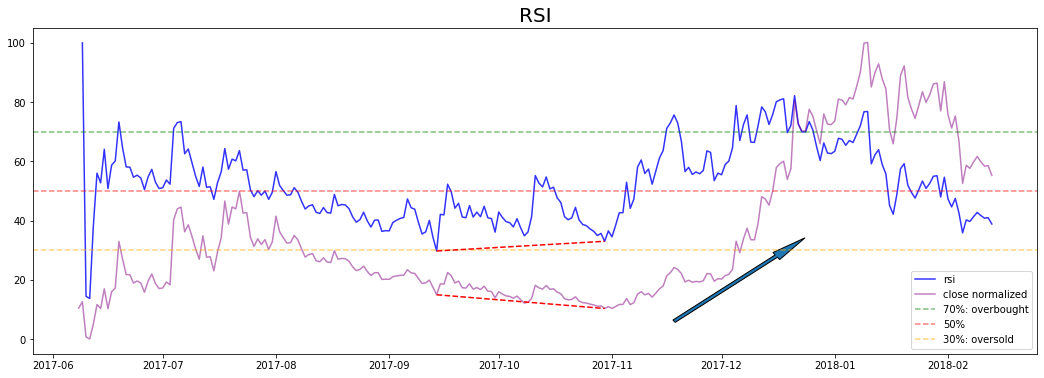

In [ ]:
plt.figure(figsize=(18,6))
plt.title('RSI', fontsize=20)
x = pd.to_datetime(veri.index)
plt.plot(x, veri['rsi'], label='rsi', alpha=0.8, color='blue')
plt.plot(x, veri['close']/4.66, label='close normalized', alpha=0.5, color='purple')
plt.axhline(y = 70, color='green', linestyle='--', alpha=0.5, label='70%: overbought')
plt.axhline(y = 50, color='red', linestyle='--', alpha=0.5, label='50%')
plt.axhline(y = 30, color='orange', linestyle='--', alpha=0.5, label='30%: oversold')

x_comp = [pd.to_datetime('2017-09-14'), pd.to_datetime('2017-10-30')]
y_rsi = [29.72, 33]
y_close = [69.6/4.66, 48/4.66]
plt.plot(x_comp, y_rsi, linestyle="--", color='r')
plt.plot(x_comp, y_close, linestyle="--", color='r')
plt.arrow(pd.to_datetime('2017-11-18'), 6, 28, 22,
         width = 1,
         head_length = 10)
plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

### StochRSI
Если RSI указывает тренды цены, то StockRSI - тренды RSI.

https://www.investopedia.com/terms/s/stochrsi.asp

$StochRSI = \frac{RSI - min[RSI]}{max[RSI] - min[RSI]}$

min и max по окну, задаваемому в `rsi_<window>`

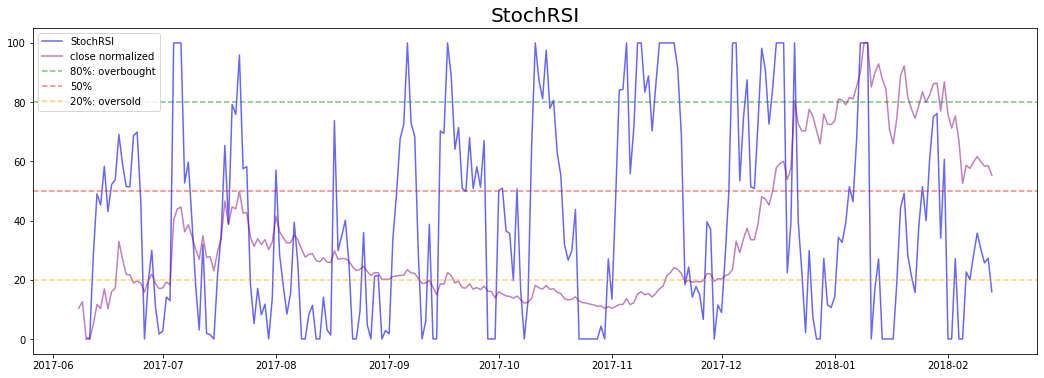

In [ ]:
plt.figure(figsize=(18,6))
plt.title('StochRSI', fontsize=20)
x = pd.to_datetime(veri.index)
plt.plot(x, veri['stochrsi'], label='StochRSI', alpha=0.6, color='blue')
plt.plot(x, veri['close']/4.66, label='close normalized', alpha=0.5, color='purple')
plt.axhline(y = 80, color='green', linestyle='--', alpha=0.5, label='80%: overbought')
plt.axhline(y = 50, color='red', linestyle='--', alpha=0.5, label='50%')
plt.axhline(y = 20, color='orange', linestyle='--', alpha=0.5, label='20%: oversold')
plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

### WT - Wave Trend
Другой способ следить за трендами и вероятностями их смены.

https://medium.com/@samuel.mcculloch/lets-take-a-look-at-wavetrend-with-crosses-lazybear-s-indicator-2ece1737f72f

```
esa = EMA[N] of middle
d = EMA[N] of abs(Middle - esa)
ci = (middle — esa) / (0.015 * d)
tci = EMA[N] of ci
wt1 = tci
wt2 = SMA(tci)
```
ema - exponential moving average - экспоненциальное скользящее среднее <br>
sma - simple moving average - скользящее среднее

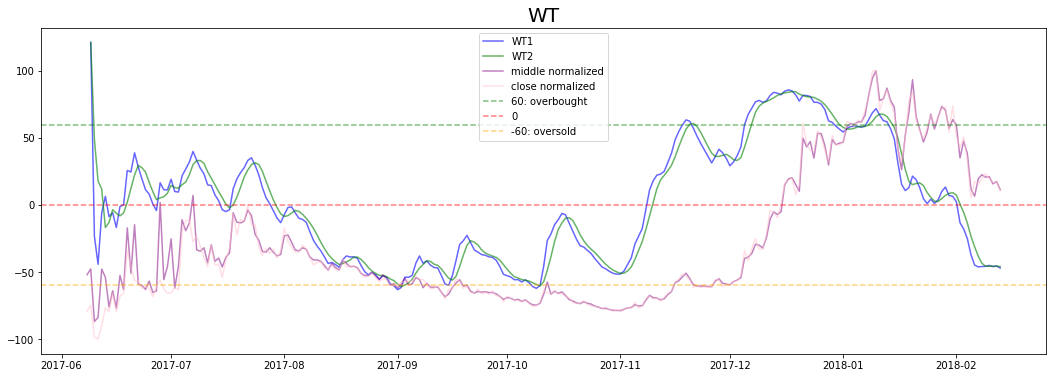

In [ ]:
plt.figure(figsize=(18,6))
plt.title('WT', fontsize=20)
x = pd.to_datetime(veri.index)
plt.plot(x, veri['wt1'], label='WT1', alpha=0.6, color='blue')
plt.plot(x, veri['wt2'], label='WT2', alpha=0.6, color='green')
plt.plot(x, veri['middle']/2.33 - 100, label='middle normalized', alpha=0.5, color='purple')
plt.plot(x, veri['close']/2.33 - 100, label='close normalized', alpha=0.5, color='pink')
plt.axhline(y = 60, color='green', linestyle='--', alpha=0.5, label='60: overbought')
plt.axhline(y = 0, color='red', linestyle='--', alpha=0.5, label='0')
plt.axhline(y = -60, color='orange', linestyle='--', alpha=0.5, label='-60: oversold')
plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

### TRIX - Triple Exponential Average
Еще один способ отслеживать тренды. Хорошо фильтрует шум. Один из лучших индикаторов разворота тренда.

Можно интерпретировать пересечение 0 вверх как сигнал к покупку и вниз как сигнал к продаже.

https://www.investopedia.com/articles/technical/02/092402.asp

```
TripleEMA = EMA of EMA of EMA
LastTripleEMA =  TripleEMA of the last period
TRIX = (TripleEMA - LastTripleEMA) -  * 100 / LastTripleEMA
```



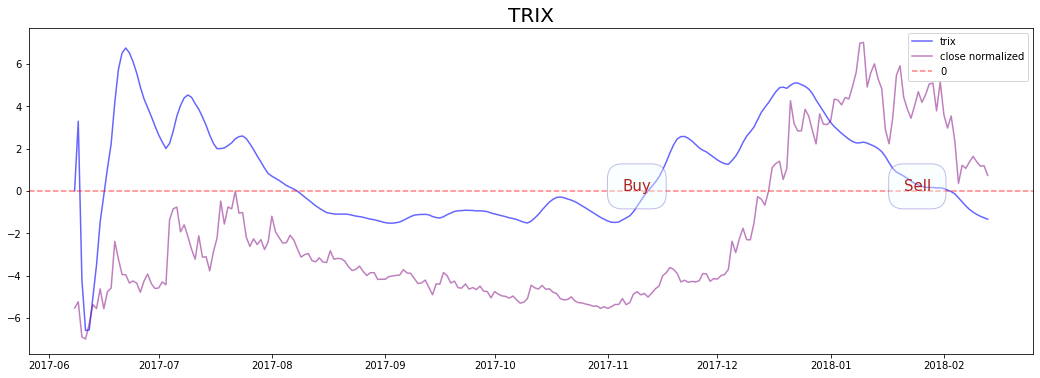

In [ ]:
plt.figure(figsize=(18,6))
plt.title('TRIX', fontsize=20)
x = pd.to_datetime(veri.index)
plt.plot(x, veri['trix'], label='trix', alpha=0.6, color='blue')
plt.plot(x, veri['close']/33.3 - 7, label='close normalized', alpha=0.5, color='purple')
plt.axhline(y = 0, color='red', linestyle='--', alpha=0.5, label='0')

# Добавить текст
plt.text(
    pd.to_datetime('2017-11-05'), 0,  # Позиция начала текста
    'Buy',  # Собственно сам текст
    fontsize=15,  # Размер шрифта
    color='firebrick',  # Цвет букв
    bbox=dict(  # Параметры рамки ограничивающей текст
        alpha=0.4, # Прозрачность фона рамки
        edgecolor='slateblue',  # цвет рамки
        facecolor='azure',  # цвет подложки
        pad=1., # отступ рамки от текст
        boxstyle='round'  # форма рамки
    )
)
# Добавить текст
plt.text(
    pd.to_datetime('2018-01-21'), 0,  # Позиция начала текста
    'Sell',  # Собственно сам текст
    fontsize=15,  # Размер шрифта
    color='firebrick',  # Цвет букв
    bbox=dict(  # Параметры рамки ограничивающей текст
        alpha=0.4, # Прозрачность фона рамки
        edgecolor='slateblue',  # цвет рамки
        facecolor='azure',  # цвет подложки
        pad=1., # отступ рамки от текст
        boxstyle='round'  # форма рамки
    )
)

plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

### TEMA - другой Triple Exponential Average



https://www.forextraders.com/forex-education/forex-technical-analysis/triple-exponential-moving-average-the-tema-indicator/

```
TEMA = (3 x EMA) - (3 x EMA of EMA) + (EMA of EMA of EMA)
```



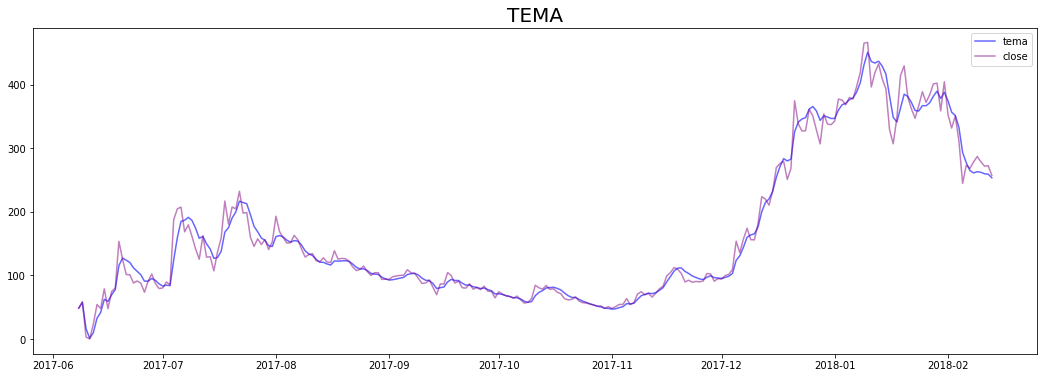

In [ ]:
plt.figure(figsize=(18,6))
plt.title('TEMA', fontsize=20)
x = pd.to_datetime(veri.index)
plt.plot(x, veri['close_12_tema'], label='tema', alpha=0.6, color='blue')
plt.plot(x, veri['close'], label='close', alpha=0.5, color='purple')
# plt.axhline(y = 60, color='green', linestyle='--', alpha=0.5, label='60: overbought')
# plt.axhline(y = 0, color='red', linestyle='--', alpha=0.5, label='0')
# plt.axhline(y = -60, color='orange', linestyle='--', alpha=0.5, label='-60: oversold')
plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

### VR - Volume Variation Index
Измеряет накал биржевой цены с точки зрения объема торгов. Индекс VR может показать импульс торговли на фондовом рынке, а затем уловить тенденцию цены акций. <br>
Когда объем торгов сильно сокращается, а индекс VR растет из области низких цен, самое время покупать. 

https://help.eaglesmarkets.com/hc/en-us/articles/900002867026-Summary-of-volume-variation-index

```
AV = trading volume of stock price rising within n days
AVS = Σ AV within n days

Bv = trading volume of stock price falling within n days
BVS = n day ∑ bv

CV = n-day trading volume of stock price in n days
CVS = n-day ∑ cv

VR=（AVS+1/2CVS）/（BVS+1/2CVS）

MAVR = M-day simple moving average of VR

Parameter n is 24, parameter m is 6. 
```



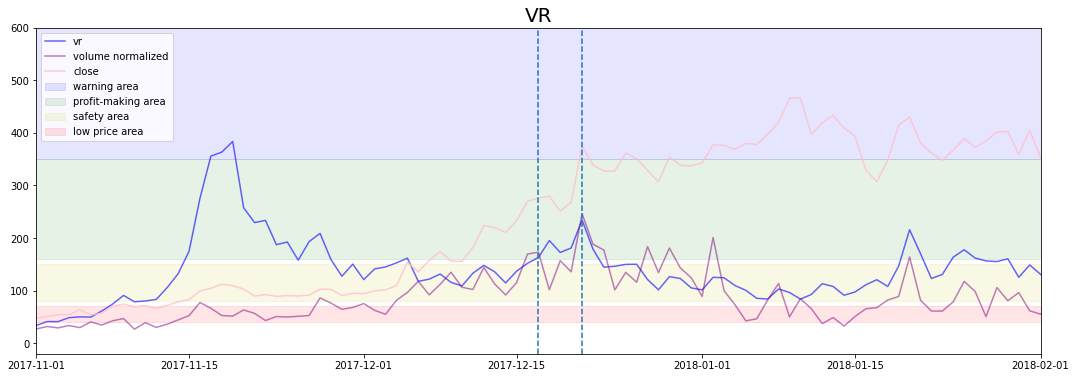

In [ ]:
plt.figure(figsize=(18,6))
plt.title('VR', fontsize=20)
x = pd.to_datetime(veri.index)
plt.plot(x, veri['vr_20'], label='vr', alpha=0.6, color='blue')
plt.plot(x, veri['volume']/10000, label='volume normalized', alpha=0.5, color='purple')
plt.plot(x, veri['close'], label='close', alpha=0.8, color='pink')
plt.fill_between(x, 350, veri['vr_10'].max(), alpha=0.1, color='b', label='warning area')
plt.fill_between(x, 160, 350, alpha=0.1, color='g', label='profit-making area')
plt.fill_between(x, 80, 150, alpha=0.1, color='y', label='safety area')
plt.fill_between(x, 40, 70, alpha=0.1, color='r', label='low price area')

plt.axvline(pd.to_datetime('2017-12-17'), linestyle='--')
plt.axvline(pd.to_datetime('2017-12-21'), linestyle='--')
plt.legend()
plt.xlim((pd.to_datetime('2017-11-01'), pd.to_datetime('2018-02-01')))
plt.ylim((-20, 600))
plt.show()

### WR - Williams Overbought/Oversold Index
Похож на StochRSI

https://www.investopedia.com/terms/w/williamsr.asp

$WR = \frac{HighestHigh-Close}{HighestHigh-LowestLow}$



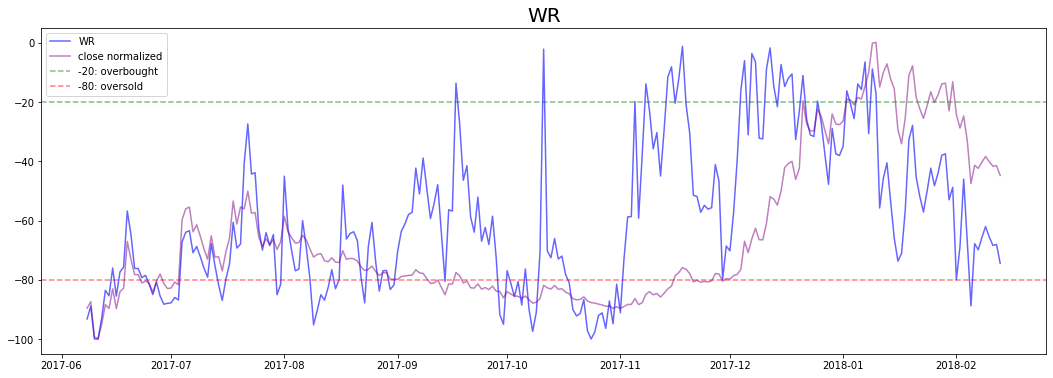

In [ ]:
plt.figure(figsize=(18,6))
plt.title('WR', fontsize=20)
x = pd.to_datetime(veri.index)
plt.plot(x, veri['wr'], label='WR', alpha=0.6, color='blue')
plt.plot(x, veri['close']/4.66 - 100, label='close normalized', alpha=0.5, color='purple')
plt.axhline(y = -20, color='green', linestyle='--', alpha=0.5, label='-20: overbought')
plt.axhline(y = -80, color='red', linestyle='--', alpha=0.5, label='-80: oversold')
plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

### CCI - Commodity Channel Index
Если cci возрастает с отрицательных/околонулевых значений до 100, возможно начало нового тренда вверх. <br>
Если cci убывает с положительных/околонулевых значений до -100, возможно начало нового тренда вниз. <br>
Если цена возрастает, а cci убывает, это говорит о слабости тренда.

https://www.investopedia.com/terms/c/commoditychannelindex.asp

$CCI = \frac{TypicalPrice-MovingAverage}{0.015*MeanDeviation}, \space TypicalPrice=\sum\frac{High+Low+Close}{3}$



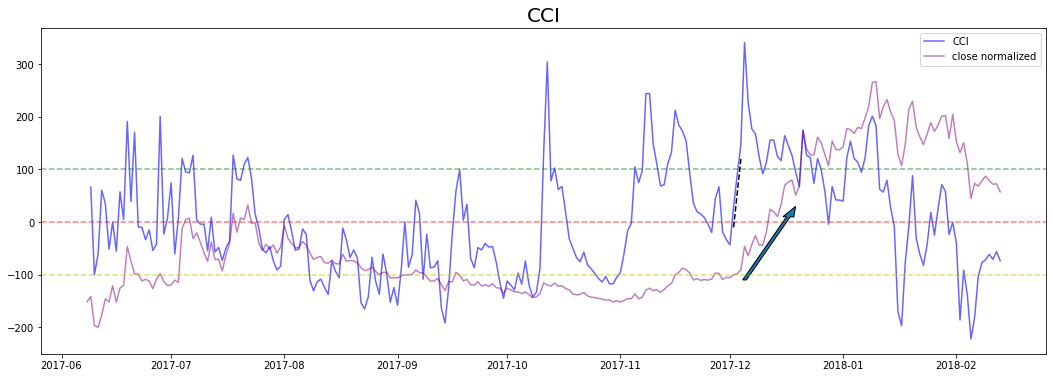

In [ ]:
plt.figure(figsize=(18,6))
plt.title('CCI', fontsize=20)
x = pd.to_datetime(veri.index)
plt.plot(x, veri['cci'], label='CCI', alpha=0.6, color='blue')
plt.plot(x, veri['close'] - 200, label='close normalized', alpha=0.5, color='purple')
plt.axhline(y = 100, color='g', linestyle='--', alpha=0.5)
plt.axhline(y = 0, color='r', linestyle='--', alpha=0.5)
plt.axhline(y = -100, color='y', linestyle='--', alpha=0.5)

x_comp = [pd.to_datetime('2017-12-02'), pd.to_datetime('2017-12-04')]
y = [-10, 120]
plt.plot(x_comp, y, linestyle="--", color='k')
plt.arrow(pd.to_datetime('2017-12-05'), -110, 12, 120,
         width = 1,
         head_length = 20)
plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

### ATR - Average True Range
Индикатор волатильности рынка. ~среднее изменение

https://en.wikipedia.org/wiki/Average_true_range

$TR_t = max[(high_t-low_t), abs(high_t-close_{t-1}), abs(low_t-close_{t-1})]$ <br><br>
$ATR_n = \frac{\sum_{i=1..n}TR_i}{n}, \space ATR_t = \frac{ATR_{t-1}*(n-1) + TR_t}{n}$

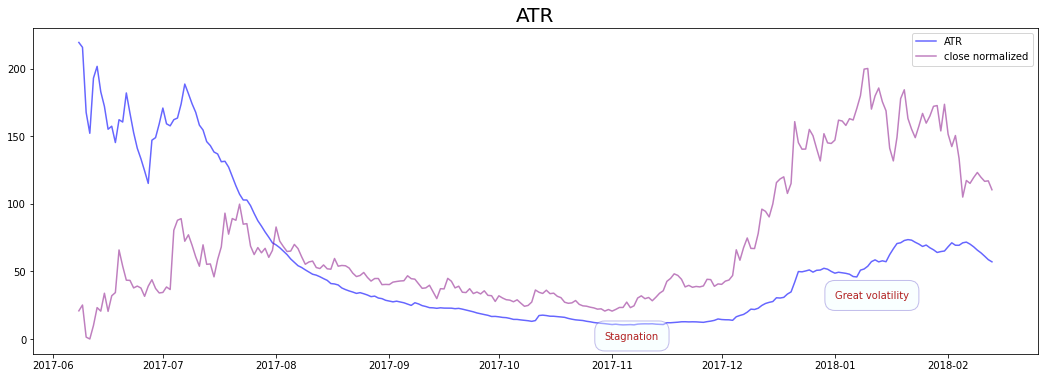

In [ ]:
plt.figure(figsize=(18,6))
plt.title('ATR', fontsize=20)
x = pd.to_datetime(veri.index)
plt.plot(x, veri['atr'], label='ATR', alpha=0.6, color='blue')
plt.plot(x, veri['close']/2.33, label='close normalized', alpha=0.5, color='purple')

# Добавить текст
plt.text(
    pd.to_datetime('2018-01-01'), 30,  # Позиция начала текста
    'Great volatility',  # Собственно сам текст
    fontsize=10,  # Размер шрифта
    color='firebrick',  # Цвет букв
    bbox=dict(  # Параметры рамки ограничивающей текст
        alpha=0.4, # Прозрачность фона рамки
        edgecolor='slateblue',  # цвет рамки
        facecolor='azure',  # цвет подложки
        pad=1., # отступ рамки от текст
        boxstyle='round'  # форма рамки
    )
)
# Добавить текст
plt.text(
    pd.to_datetime('2017-10-30'), 0,  # Позиция начала текста
    'Stagnation',  # Собственно сам текст
    fontsize=10,  # Размер шрифта
    color='firebrick',  # Цвет букв
    bbox=dict(  # Параметры рамки ограничивающей текст
        alpha=0.4, # Прозрачность фона рамки
        edgecolor='slateblue',  # цвет рамки
        facecolor='azure',  # цвет подложки
        pad=1., # отступ рамки от текст
        boxstyle='round'  # форма рамки
    )
)
plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

### Supertrend
Индакатор трендов. Дает достаточно точные знаки к покупке\продаже. Использует ATR (индикатор волатильности). <br>
Параметры: период (для ATR) и множитель (на который домножается ATR).

Покупаем, если перешли с Upper на Lower; продаем, если перешли с Lower на Upper.<br>
Может плохо себя вести в условиях сильной волатильности. Хорошо комбинировать с индиаторами, опирающимися на volume (объем торгов), RSI, MACD.

https://economictimes.indiatimes.com/markets/stocks/news/how-to-use-supertrend-indicator-to-find-buying-and-selling-opportunities-in-market/articleshow/54492970.cms 

https://medium.com/codex/step-by-step-implementation-of-the-supertrend-indicator-in-python-656aa678c111

$HLA = \frac{high + low}{2}$

$BasicUpperBand = HLA + multiplayer * ATR$ <br>
$BasicLowerBand = HLA - multiplayer * ATR$ <br>
$CurrentUpperBand:$ если $(BasicUpperBand < PrevUpperBand)$ или $(PrevClose > PrevUpperBand)$, то $= BasicUpperBand$, посчитанный на этом шаге. Иначе $= PrevUpperBand$. <br>
$CurrentLowerBand$ аналогично

$Supertrend:$
- если $PrevSuperTrend = PrevUpperBand$ и $CurrentClose < CurrentUpperBand$, то $= CurrentUpperBand$
- если $PrevSuperTrend = PrevUpperBand$ и $CurrentClose > CurrentUpperBand$, то $= CurrentLowerBand$
- если $PrevSuperTrend = PrevLowerBand$ и $CurrentClose > CurrentLowerBand$, то $= CurrentLowerBand$
- если $PrevSuperTrend = PrevLowerBand$ и $CurrentClose < CurrentLowerBand$, то $= CurrentUpperBand$




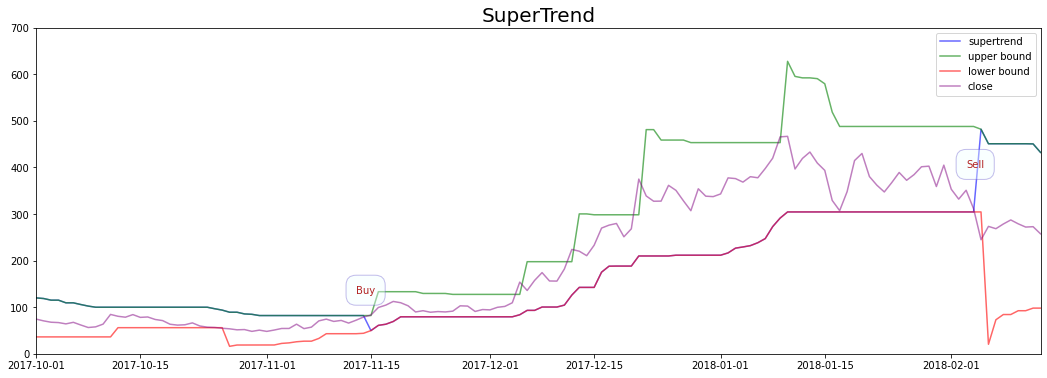

In [ ]:
plt.figure(figsize=(18,6))
plt.title('SuperTrend', fontsize=20)
x = pd.to_datetime(veri.index)
plt.plot(x, veri['supertrend'], label='supertrend', alpha=0.6, color='blue')
plt.plot(x, veri['supertrend_ub'], label='upper bound', alpha=0.6, color='g')
plt.plot(x, veri['supertrend_lb'], label='lower bound', alpha=0.6, color='r')
plt.plot(x, veri['close'], label='close', alpha=0.5, color='purple')

# Добавить текст
plt.text(
    pd.to_datetime('2017-11-13'), 130,  # Позиция начала текста
    'Buy',  # Собственно сам текст
    fontsize=10,  # Размер шрифта
    color='firebrick',  # Цвет букв
    bbox=dict(  # Параметры рамки ограничивающей текст
        alpha=0.4, # Прозрачность фона рамки
        edgecolor='slateblue',  # цвет рамки
        facecolor='azure',  # цвет подложки
        pad=1., # отступ рамки от текст
        boxstyle='round'  # форма рамки
    )
)
# Добавить текст
plt.text(
    pd.to_datetime('2018-02-03'), 400,  # Позиция начала текста
    'Sell',  # Собственно сам текст
    fontsize=10,  # Размер шрифта
    color='firebrick',  # Цвет букв
    bbox=dict(  # Параметры рамки ограничивающей текст
        alpha=0.4, # Прозрачность фона рамки
        edgecolor='slateblue',  # цвет рамки
        facecolor='azure',  # цвет подложки
        pad=1., # отступ рамки от текст
        boxstyle='round'  # форма рамки
    )
)
plt.legend()
plt.xlim((pd.to_datetime('2017-10-01'), pd.to_datetime('2018-02-13')))
plt.ylim((0, 700))
plt.show()

### DMI - Directional Movement Index
Индикатор тренда и его силы. <br>
Если PDI выше, чем MDI, тренд восходящий и наоборот. Пересечения - индикаторы к покупке и продаже. 


https://www.investopedia.com/terms/d/dmi.asp

$+DM = CurrentHigh - PrevHigh$ <br>
$-DM = PrevLow - CurrentLow$ <br>
$Smoothed_{+/-DM} = \sum_{1..window}{DM} - \frac{\sum_{1..window}{DM}}{window} + CurrentDM$ 

$PDI = \frac{Smoothed_{+DM}}{ATR} * 100$

$MDI = \frac{Smoothed_{-DM}}{ATR} * 100$

$DX = \frac{|PDI-MDI|}{|PDI+MDI|} * 100$

$ADX$ - average of $DX$

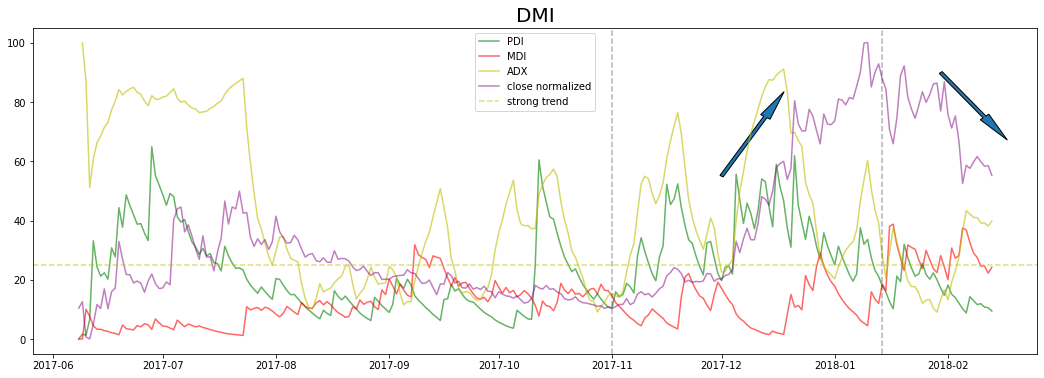

In [ ]:
plt.figure(figsize=(18,6))
plt.title('DMI', fontsize=20)
x = pd.to_datetime(veri.index)
plt.plot(x, veri['pdi'], label='PDI', alpha=0.6, color='g')
plt.plot(x, veri['mdi'], label='MDI', alpha=0.6, color='r')
# plt.plot(x, veri['dx'], label='DX', alpha=0.6, color='orange')
plt.plot(x, veri['adx'], label='ADX', alpha=0.6, color='y')
# plt.plot(x, veri['adxr'], label='ADXR', alpha=0.6, color='pink')
plt.plot(x, veri['close']/4.66, label='close normalized', alpha=0.5, color='purple')
plt.axhline(y=25, color='y', linestyle='--', alpha=0.5, label='strong trend')

plt.axvline(x=pd.to_datetime('2017-11-01'), color='k', linestyle='--', alpha=0.3)
plt.arrow(pd.to_datetime('2017-12-01'), 55, 12, 20,
         width = 1,
         head_length = 10)
plt.axvline(x=pd.to_datetime('2018-01-14'), color='k', linestyle='--', alpha=0.3)
plt.arrow(pd.to_datetime('2018-01-30'), 90, 12, -15,
         width = 1,
         head_length = 10)
plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

### KDJ Indicator
Стохастический осциллятор - индикатор трендов цены <br>
Позволяет довольно точно определять точки разворота тренда, но во время неопределенности на рынке генерирует ложные сигналы. Очень чувствительный. <br>
Если линии расходятся и направлены в одну сторону, то разворот состоялся, тренд сильный. А пилообразный профиль линий говорит о неуверенном движении цены – сигнал не самый хороший.<br>
Сложно вручную анализировать поведение, но может дать много информации.

https://en.wikipedia.org/wiki/Stochastic_oscillator <br>
https://russianblogs.com/article/6080687610/

$RSV = \frac{Close - LowestLowWindow}{HighestHighWindow - LowestLowWindow} * 100$

$K = SMA(RSV, 3, 1)$<br>
$D = SMA(K, 3, 1)$ <br>
$J = 3K - 2D$

sma - simple moving average - скользящее среднее

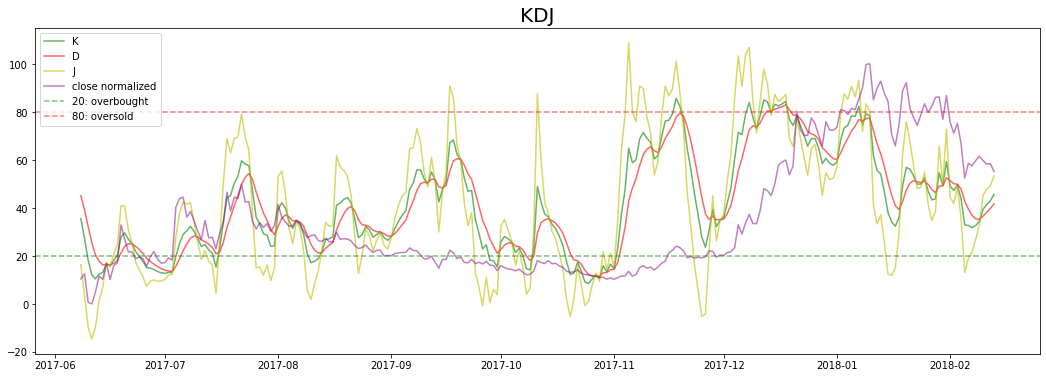

In [ ]:
plt.figure(figsize=(18,6))
plt.title('KDJ', fontsize=20)
x = pd.to_datetime(veri.index)
plt.plot(x, veri['kdjk'], label='K', alpha=0.6, color='g')
plt.plot(x, veri['kdjd'], label='D', alpha=0.6, color='r')
plt.plot(x, veri['kdjj'], label='J', alpha=0.6, color='y')
plt.plot(x, veri['close']/4.66, label='close normalized', alpha=0.5, color='purple')
plt.axhline(y=20, color='green', linestyle='--', alpha=0.5, label='20: overbought')
plt.axhline(y=80, color='red', linestyle='--', alpha=0.5, label='80: oversold')
plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

### CR - Energy Index
Использует связь между high, low, вчерашней middle, чтобы предсказать тренды.

Если CR слишком быстро отходит от средней линии, рынок может быть перекуплен или перепродан. Переход через среднюю линию указывает на возможный разворот рынка. <br>
Когда CR падает ниже 40, вероятность того, что цена акции сформирует дно, довольно высока. Когда CR выше 300-400, цена акций может легко развернуться вниз.

https://support.futunn.com/en/topic167/?lang=en-us

*Strong market* - рынок, на котором продавцов больше, чем покупателей, а цены имеют тенденцию к росту. <br>
*Weak market* - рынок, на котором мало покупателей и много продавцов и наблюдается тенденция к снижению цен.

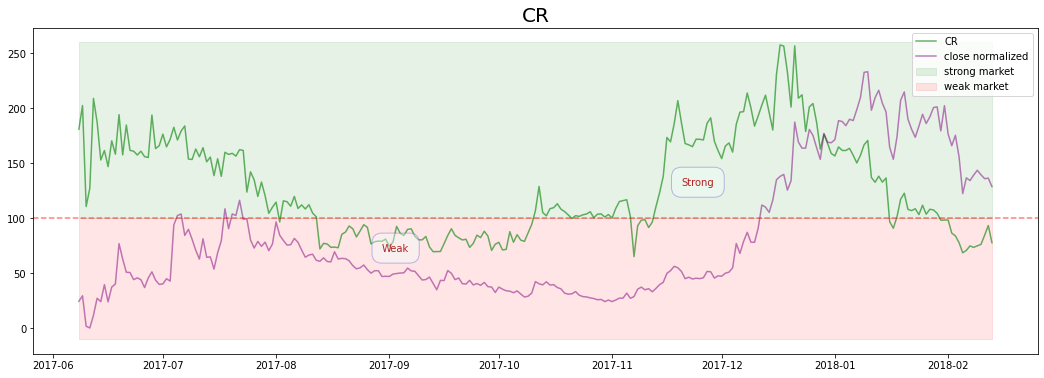

In [ ]:
plt.figure(figsize=(18,6))
plt.title('CR', fontsize=20)
x = pd.to_datetime(veri.index)
plt.plot(x, veri['cr'], label='CR', alpha=0.6, color='g')
plt.plot(x, veri['close']/2, label='close normalized', alpha=0.5, color='purple')
plt.axhline(y=100, color='r', linestyle='--', alpha=0.5)
plt.fill_between(x, 100, 260, alpha=0.1, color='g', label='strong market')
plt.fill_between(x, -10, 100, alpha=0.1, color='r', label='weak market')
# plt.axhline(y=80, color='red', linestyle='--', alpha=0.5, label='80: oversold')

# Добавить текст
plt.text(
    pd.to_datetime('2017-08-30'), 70,  # Позиция начала текста
    'Weak',  # Собственно сам текст
    fontsize=10,  # Размер шрифта
    color='firebrick',  # Цвет букв
    bbox=dict(  # Параметры рамки ограничивающей текст
        alpha=0.4, # Прозрачность фона рамки
        edgecolor='slateblue',  # цвет рамки
        facecolor='azure',  # цвет подложки
        pad=1., # отступ рамки от текст
        boxstyle='round'  # форма рамки
    )
)
# Добавить текст
plt.text(
    pd.to_datetime('2017-11-20'), 130,  # Позиция начала текста
    'Strong',  # Собственно сам текст
    fontsize=10,  # Размер шрифта
    color='firebrick',  # Цвет букв
    bbox=dict(  # Параметры рамки ограничивающей текст
        alpha=0.4, # Прозрачность фона рамки
        edgecolor='slateblue',  # цвет рамки
        facecolor='azure',  # цвет подложки
        pad=1., # отступ рамки от текст
        boxstyle='round'  # форма рамки
    )
)
plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

### Bollinger Bands
Отражает волатильность (ширина полосы) и общее направление цены.

Можно покупать, когда цена заходит за нижнюю границу и продавать, когда цена заходит за верхнюю. <br>
Можно играть на волатильности, когда ширина полосы большая.


https://en.wikipedia.org/wiki/Bollinger_Bands

Boll - скользящее среднее <br>
Upper bound больше на K * стандартное отклонение <br>
Lower bound меньше на K * стандартное отклонение

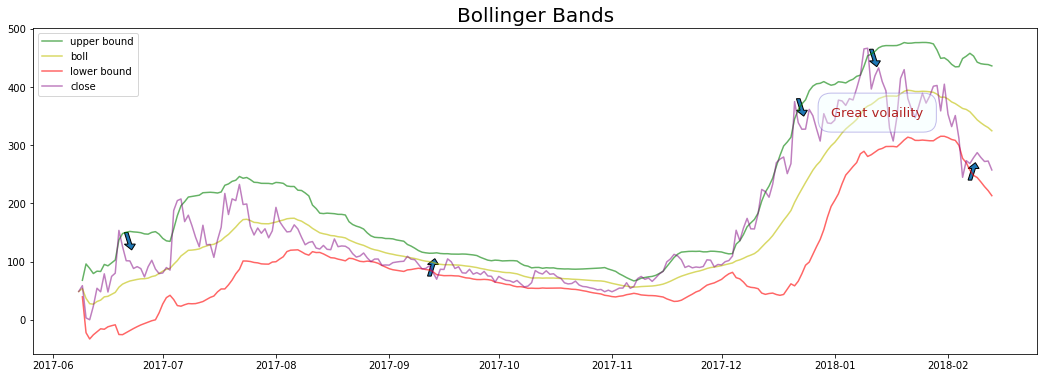

In [ ]:
plt.figure(figsize=(18,6))
plt.title('Bollinger Bands', fontsize=20)
x = pd.to_datetime(veri.index)
plt.plot(x, veri['boll_ub'], label='upper bound', alpha=0.6, color='g')
plt.plot(x, veri['boll'], label='boll', alpha=0.6, color='y')
plt.plot(x, veri['boll_lb'], label='lower bound', alpha=0.6, color='r')
plt.plot(x, veri['close'], label='close', alpha=0.5, color='purple')
# plt.axhline(y=20, color='green', linestyle='--', alpha=0.5, label='20: overbought')
# plt.axhline(y=80, color='red', linestyle='--', alpha=0.5, label='80: oversold')

# Добавить текст
plt.text(
    pd.to_datetime('2017-12-31'), 350,  # Позиция начала текста
    'Great volaility',  # Собственно сам текст
    fontsize=13,  # Размер шрифта
    color='firebrick',  # Цвет букв
    bbox=dict(  # Параметры рамки ограничивающей текст
        alpha=0.4, # Прозрачность фона рамки
        edgecolor='slateblue',  # цвет рамки
        facecolor='azure',  # цвет подложки
        pad=1., # отступ рамки от текст
        boxstyle='round'  # форма рамки
    )
)
plt.arrow(pd.to_datetime('2017-12-22'), 380, 1, -20,
         width = 1,
         head_length = 10)
plt.arrow(pd.to_datetime('2018-01-11'), 465, 1, -20,
         width = 1,
         head_length = 10)
plt.arrow(pd.to_datetime('2017-06-21'), 150, 1, -20,
         width = 1,
         head_length = 10)
plt.arrow(pd.to_datetime('2017-09-12'), 75, 1, 20,
         width = 1,
         head_length = 10)
plt.arrow(pd.to_datetime('2018-02-07'), 240, 1, 20,
         width = 1,
         head_length = 10)
plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

### MACD - Moving Average Convergence Divergence
Для выявления изменений в силе, направлении, импульсе и продолжительности тренда в цене акции. Хорошо использовать с RSI.

Когда MACD выходит вверх за сигнальную линию, это сигнал к покупке. Вниз - к продаже.

https://en.wikipedia.org/wiki/MACD <br>
https://www.investopedia.com/terms/m/macd.asp

MACD = 26-period EMA - the 12-period EMA <br>
MACDS = macd_9_ema - сигнальная линия <br>


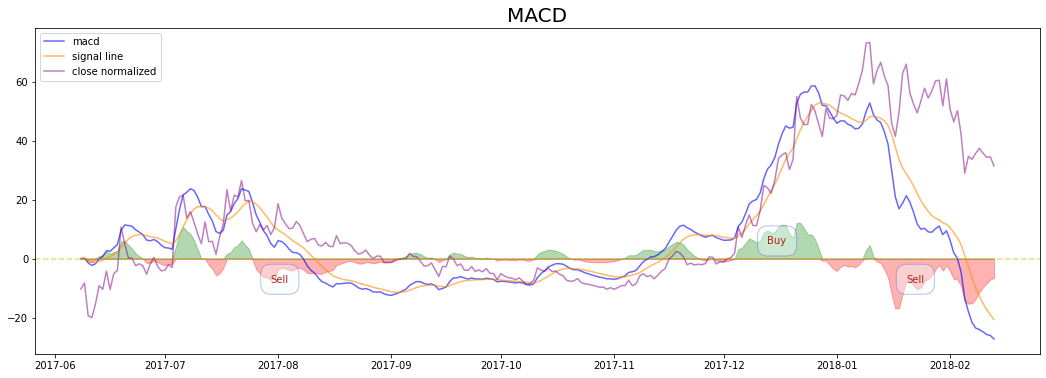

In [ ]:
plt.figure(figsize=(18,6))
plt.title('MACD', fontsize=20)
x = pd.to_datetime(veri.index)
plt.plot(x, veri['macd'], label='macd', alpha=0.6, color='b')
plt.plot(x, veri['macds'], label='signal line', alpha=0.6, color='darkorange')
plt.fill_between(x, 0, veri['macdh'].clip(0, None), color='g', alpha=0.3)
plt.fill_between(x, 0, veri['macdh'].clip(None, 0), color='r', alpha=0.3)
plt.plot(x, veri['close']/5 - 20, label='close normalized', alpha=0.5, color='purple')
plt.axhline(y=0, color='y', linestyle='--', alpha=0.5)

# Добавить текст
plt.text(
    pd.to_datetime('2017-07-30'), -8,  # Позиция начала текста
    'Sell',  # Собственно сам текст
    fontsize=10,  # Размер шрифта
    color='firebrick',  # Цвет букв
    bbox=dict(  # Параметры рамки ограничивающей текст
        alpha=0.4, # Прозрачность фона рамки
        edgecolor='slateblue',  # цвет рамки
        facecolor='azure',  # цвет подложки
        pad=1., # отступ рамки от текст
        boxstyle='round'  # форма рамки
    )
)
# Добавить текст
plt.text(
    pd.to_datetime('2017-12-13'), 5,  # Позиция начала текста
    'Buy',  # Собственно сам текст
    fontsize=10,  # Размер шрифта
    color='firebrick',  # Цвет букв
    bbox=dict(  # Параметры рамки ограничивающей текст
        alpha=0.4, # Прозрачность фона рамки
        edgecolor='slateblue',  # цвет рамки
        facecolor='azure',  # цвет подложки
        pad=1., # отступ рамки от текст
        boxstyle='round'  # форма рамки
    )
)
# Добавить текст
plt.text(
    pd.to_datetime('2018-01-20'), -8,  # Позиция начала текста
    'Sell',  # Собственно сам текст
    fontsize=10,  # Размер шрифта
    color='firebrick',  # Цвет букв
    bbox=dict(  # Параметры рамки ограничивающей текст
        alpha=0.4, # Прозрачность фона рамки
        edgecolor='slateblue',  # цвет рамки
        facecolor='azure',  # цвет подложки
        pad=1., # отступ рамки от текст
        boxstyle='round'  # форма рамки
    )
)
plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

### PPO - Percentage Price Oscillator
То же, что и MACD, но немного по-другому считаем. <br>
В то время как MACD измеряет абсолютную разницу между двумя скользящими средними, PPO превращает эту величину в относительную, деля разницу на более медленную скользящую среднюю (26-дневная EMA).

https://school.stockcharts.com/doku.php?id=technical_indicators:price_oscillators_ppo

$PPO = \frac{12-day \space EMA \space - \space 26-day \space EMA}{26-day \space EMA} * 100$

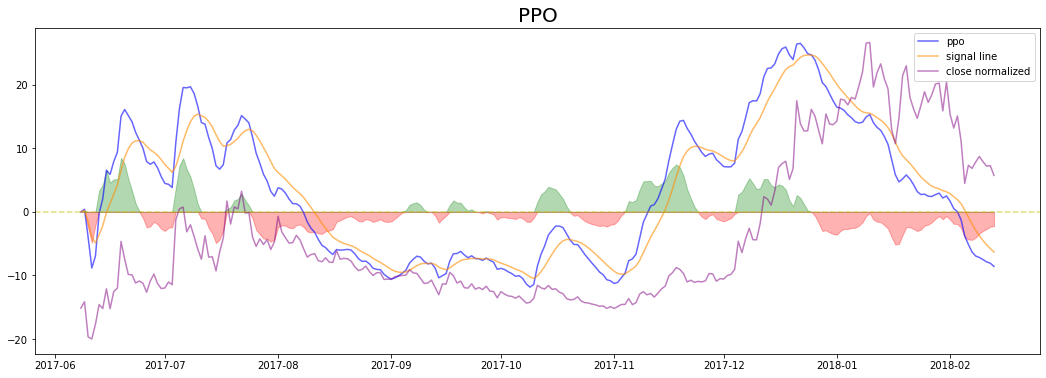

In [ ]:
plt.figure(figsize=(18,6))
plt.title('PPO', fontsize=20)
x = pd.to_datetime(veri.index)
plt.plot(x, veri['ppo'], label='ppo', alpha=0.6, color='b')
plt.plot(x, veri['ppos'], label='signal line', alpha=0.6, color='darkorange')
plt.fill_between(x, 0, veri['ppoh'].clip(0, None), color='g', alpha=0.3)
plt.fill_between(x, 0, veri['ppoh'].clip(None, 0), color='r', alpha=0.3)
plt.plot(x, veri['close']/10 - 20, label='close normalized', alpha=0.5, color='purple')
plt.axhline(y=0, color='y', linestyle='--', alpha=0.5)
plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

### Volume Weighted Moving Average
Это средняя цена, по которой торговалась ценная бумага в течение дня, основанная как на объеме, так и на цене.

Применяется к внутридневной информации с интервалами в 1-5+ минут. Обнуляется каждый день.

Если цена выше VWMA, это хороший момент, чтобы продать. Если цена ниже VWMA, это хороший момент, чтобы купить.

https://www.investopedia.com/articles/trading/11/trading-with-vwap-mvwap.asp

$TPV = \frac{high+low+close}{3} * volume$

$VWMA = \frac{comulative \space TPV}{comulative \space volume}$

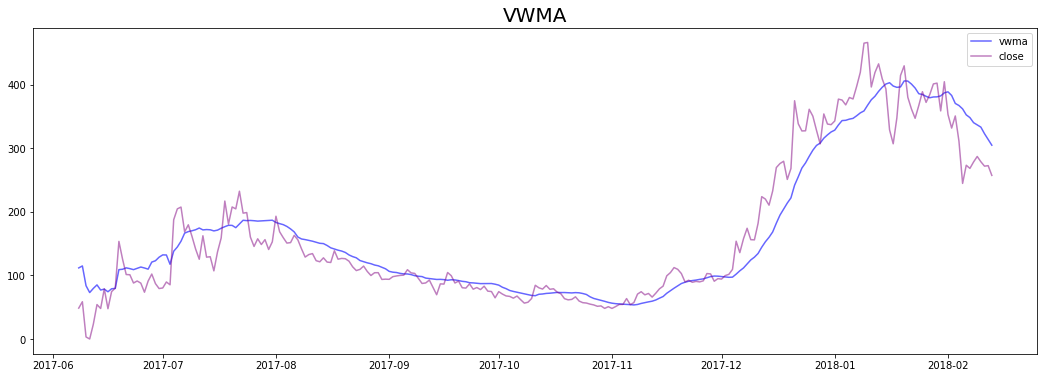

In [ ]:
plt.figure(figsize=(18,6))
plt.title('VWMA', fontsize=20)
x = pd.to_datetime(veri.index)
plt.plot(x, veri['vwma'], label='vwma', alpha=0.6, color='b')
plt.plot(x, veri['close'], label='close', alpha=0.5, color='purple')
# plt.axhline(y=0, color='y', linestyle='--', alpha=0.5)
plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

### CHOP - Choppiness Index
Choppiness - торговля против тренда (trading sideways), противоположность сильному тренду.

Считается, что за длительным choppy периодом следует длительный период тренда (сильного, направленного движения) и наоборот.

Можно сочетать с линиями тренда, чтобы предсказывать развороты.

https://www.tradingview.com/education/choppinessindex/

$CHOP=  \frac{LOG_{10}( \frac{\sum_{1..window}{ATR_1}}{( HighestHighWindow - LowestLowWindow ) })}{LOG_{10}(n)} * 100$

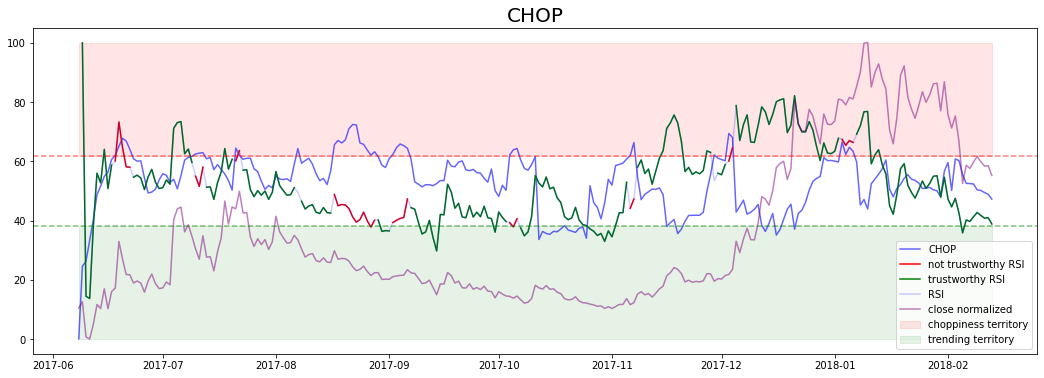

In [ ]:
plt.figure(figsize=(18,6))
plt.title('CHOP', fontsize=20)
x = pd.to_datetime(veri.index)
rsi_chopped = veri['rsi'].copy()
rsi_not_chopped = veri['rsi'].copy()
rsi_not_chopped[veri['chop'] > 61.8] = None
rsi_chopped[veri['chop'] < 61.8] = None
plt.plot(x, veri['chop'], label='CHOP', alpha=0.6, color='b')
plt.plot(x, rsi_chopped, label='not trustworthy RSI', alpha=1, color='r')
plt.plot(x, rsi_not_chopped, label='trustworthy RSI', alpha=1, color='g')
plt.plot(x, veri['rsi'], label='RSI', alpha=0.2, color='b')
plt.plot(x, veri['close']/4.66, label='close normalized', alpha=0.5, color='purple')
plt.axhline(y=61.8, color='r', linestyle='--', alpha=0.5)
plt.fill_between(x, 61.8, 100, alpha=0.1, color='r', label='choppiness territory')
plt.axhline(y=38.2, color='g', linestyle='--', alpha=0.5)
plt.fill_between(x, 0, 38.2, alpha=0.1, color='g', label='trending territory')
plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

### MFI - Money Flow Index
Использует и close, и volume

Если MFI начинает падать с высоких значений, в то время как цена продолжает расти, это сигнал разворота тренда. И наоборот. 

https://www.investopedia.com/terms/m/mfi.asp

$RawMoneyFlow = \frac{hight+low+close}{3} * volume$,<br> positive или negative в зависимости от того, изменилось hight+low+close/3 вверх или вниз с прошлого дня

$MoneyFlowRatio = \frac{14-periodPositiveMoneyFlow}{14-periodNegativeMoneyFlow}$

$MFI = 1 - \frac{1}{1 + MoneyFlowRatio}$

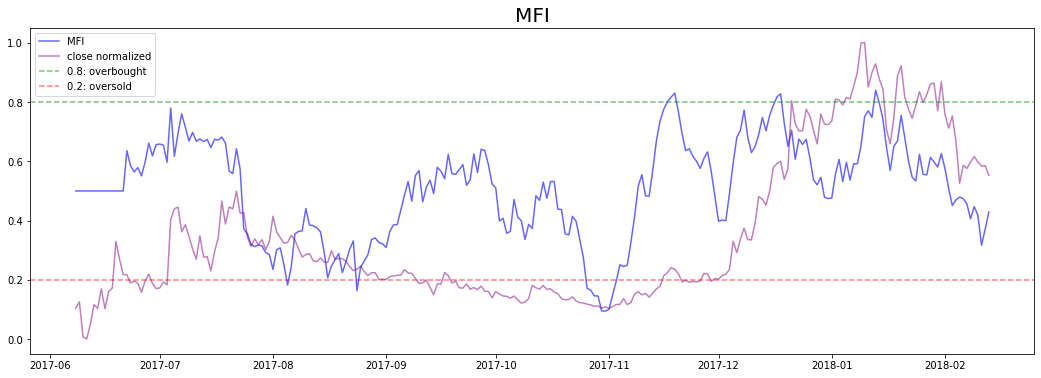

In [ ]:
plt.figure(figsize=(18,6))
plt.title('MFI', fontsize=20)
x = pd.to_datetime(veri.index)
plt.plot(x, veri['mfi'], label='MFI', alpha=0.6, color='b')
plt.plot(x, veri['close']/466, label='close normalized', alpha=0.5, color='purple')
plt.axhline(y = 0.8, color='green', linestyle='--', alpha=0.5, label='0.8: overbought')
plt.axhline(y = 0.2, color='red', linestyle='--', alpha=0.5, label='0.2: oversold')
plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

### KAMA - Kaufman's Adaptive Moving Average
Скользящее среднее, предназначенное для учета рыночного шума и волатильности.

https://school.stockcharts.com/doku.php?id=technical_indicators:kaufman_s_adaptive_moving_average

$Volatility = \sum_{1..10}{|Close-PrevClose)|}$

$Change = |Close - Close_{curr-10}|$

$Efficiency Ratio: \space ER = \frac{Change}{Volatility}$

$Smoothing Constant: SC = [ER * (\frac{2}{2+1} - \frac{2}{30+1}) + \frac{2}{30+1}]^2$

$CurrentKAMA = PrevKAMA + SC * (Price - PrevKAMA)$

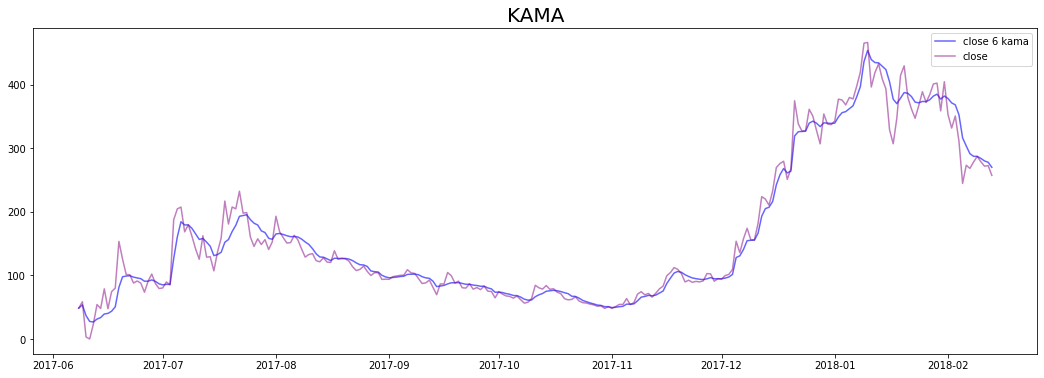

In [ ]:
plt.figure(figsize=(18,6))
plt.title('KAMA', fontsize=20)
x = pd.to_datetime(veri.index)
plt.plot(x, veri['close_10_kama'], label='close 6 kama', alpha=0.6, color='b')
plt.plot(x, veri['close'], label='close', alpha=0.5, color='purple')
plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

### Crosses

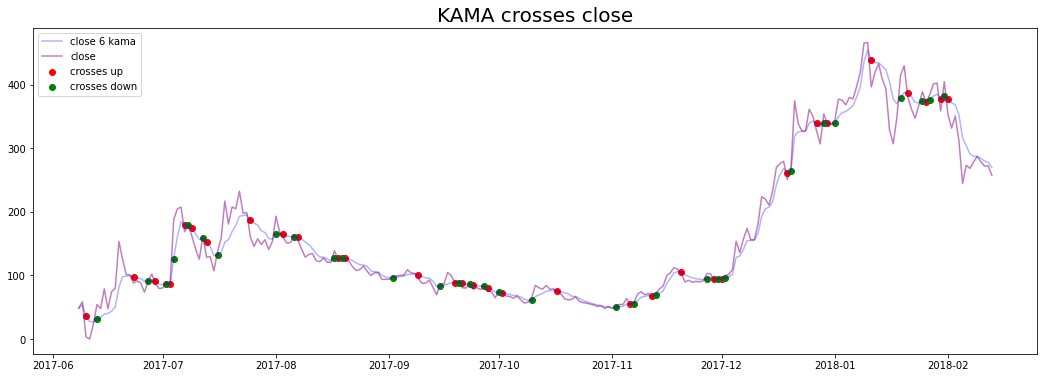

In [ ]:
plt.figure(figsize=(18,6))
plt.title('KAMA crosses close', fontsize=20)
x = pd.to_datetime(veri.index)
kama_crosses_up = veri['close_10_kama'].copy()
kama_crosses_down = veri['close_10_kama'].copy()
kama_crosses_up[veri['close_10_kama_xu_close'] == False] = None
kama_crosses_down[veri['close_10_kama_xd_close'] == False] = None
plt.plot(x, veri['close_10_kama'], label='close 6 kama', alpha=0.3, color='b')
plt.plot(x, veri['close'], label='close', alpha=0.5, color='purple')
plt.scatter(x, kama_crosses_up, label='crosses up', alpha=1, color='r')
plt.scatter(x, kama_crosses_down, label='crosses down', alpha=1, color='g')
plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

## Comparison

### Close smoothers comparison

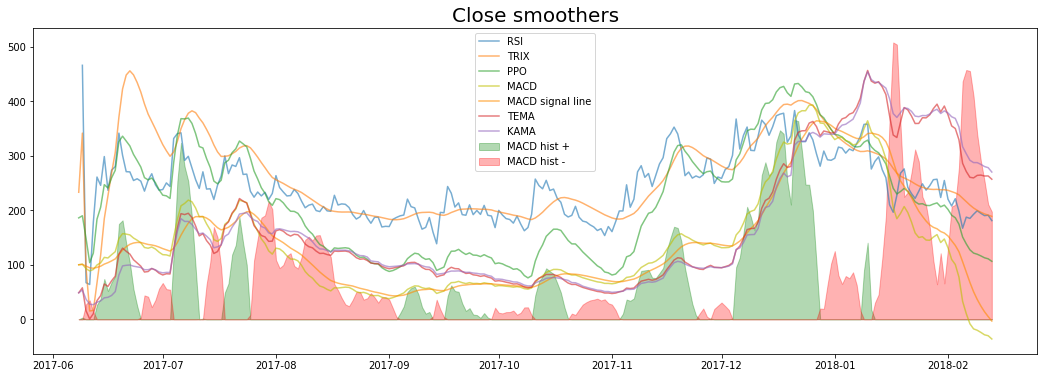

In [ ]:
plt.figure(figsize=(18,6))
plt.title('Close smoothers', fontsize=20)
x = pd.to_datetime(veri.index)
plt.plot(x, veri['rsi']*4.66, label='RSI', alpha=0.6)
plt.plot(x, veri['trix']*33 + 233, label='TRIX', alpha=0.6)

plt.plot(x, (veri['ppo']+20)*9.3, label='PPO', alpha=0.6)

plt.plot(x, (veri['macd']+20)*5, label='MACD', alpha=0.6, color='y')
plt.plot(x, (veri['macds']+20)*5, label='MACD signal line', alpha=0.6, color='darkorange')
plt.fill_between(x, 0, veri['macdh'].clip(0, None) * 30, color='g', alpha=0.3, label='MACD hist +')
plt.fill_between(x, 0, -veri['macdh'].clip(None, 0) * 30, color='r', alpha=0.3, label='MACD hist -')

plt.plot(x, veri['close_10_tema'], label='TEMA', alpha=0.6)
plt.plot(x, veri['close_10_kama'], label='KAMA', alpha=0.6)

# plt.plot(x, veri['close'], label='close', alpha=0.5, color='purple')
plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

**Выводы:**
- RSI и TRIX очень похожи. TRIX более плавный и немного запаздывает (даже с тем же окном)
- PPO другой
- MACD другой, но важны больше моменты пересечения с сигнальной линией
- TEMA и KAMA очень похожи, KAMA более плавная
- MACD hist полезен

### Volatility identificators comparison

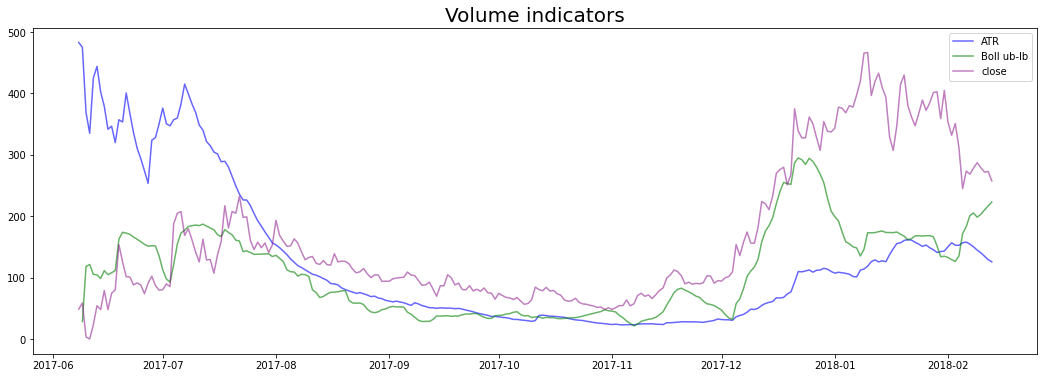

In [ ]:
plt.figure(figsize=(18,6))
plt.title('Volume indicators', fontsize=20)
x = pd.to_datetime(veri.index)
plt.plot(x, veri['atr']*2.2, label='ATR', alpha=0.6, color='blue')

# plt.plot(x, veri['boll_ub'], label='upper bound', alpha=0.6, color='g')
# plt.plot(x, veri['boll'], label='boll', alpha=0.6, color='y')
# plt.plot(x, veri['boll_lb'], label='lower bound', alpha=0.6, color='r')
plt.plot(x, veri['boll_ub'] - veri['boll_lb'], label='Boll ub-lb', alpha=0.6, color='g')

plt.plot(x, veri['close'], label='close', alpha=0.5, color='purple')

plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

**Вывод:**
- значительно разные

### The crazy ones comparison

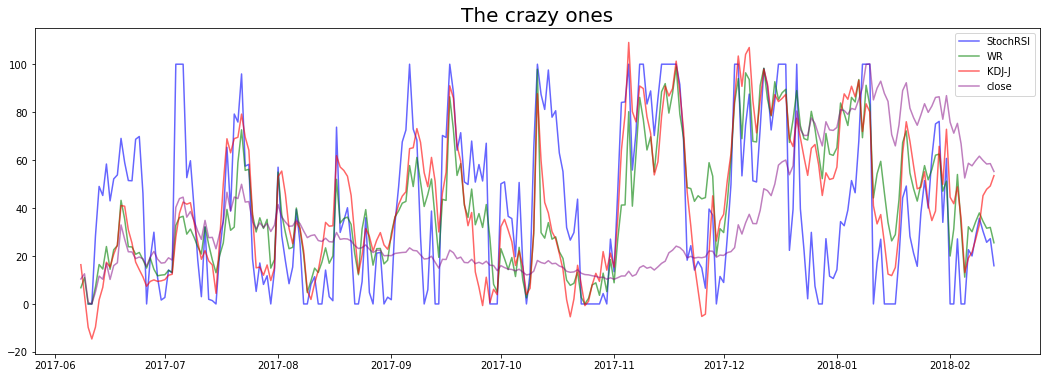

In [ ]:
plt.figure(figsize=(18,6))
plt.title('The crazy ones', fontsize=20)
x = pd.to_datetime(veri.index)
plt.plot(x, veri['stochrsi'], label='StochRSI', alpha=0.6, color='blue')

plt.plot(x, veri['wr'] + 100, label='WR', alpha=0.6, color='g')

plt.plot(x, veri['kdjj'], label='KDJ-J', alpha=0.6, color='red')

plt.plot(x, veri['close']/4.66, label='close', alpha=0.5, color='purple')

plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

**Вывод:**
- WR и KDJ-J более похожи и меют меньший разброс. Можно выбрать что-то одно

### Middle smth comparison

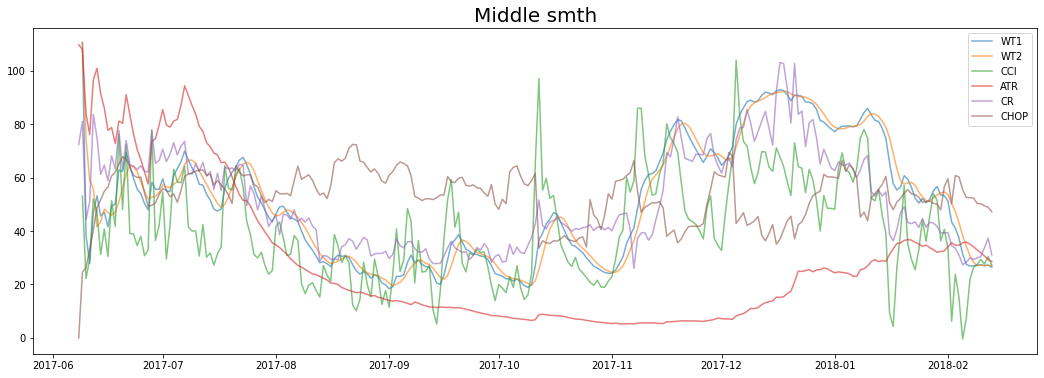

In [ ]:
plt.figure(figsize=(18,6))
plt.title('Middle smth', fontsize=20)
x = pd.to_datetime(veri.index)
plt.plot(x, veri['wt1']/2 + 50, label='WT1', alpha=0.6)
plt.plot(x, veri['wt2']/2 + 50, label='WT2', alpha=0.6)

plt.plot(x, (veri['cci']+220)/5.4, label='CCI', alpha=0.6)

plt.plot(x, veri['atr']/2, label='ATR', alpha=0.6)

# plt.plot(x, veri['pdi'], label='PDI', alpha=0.6)
# plt.plot(x, veri['mdi'], label='MDI', alpha=0.6)

# plt.plot(x, veri['kdjk'], label='KDJ-K', alpha=0.6)
# plt.plot(x, veri['kdjd'], label='KDJ-D', alpha=0.6)
# plt.plot(x, veri['kdjj'], label='KDJ-J', alpha=0.6)

plt.plot(x, veri['cr']/2.5, label='CR', alpha=0.6)

plt.plot(x, veri['chop'], label='CHOP', alpha=0.6)

# plt.plot(x, veri['close']/4.66, label='close', alpha=0.5, color='purple')

plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

**Выводы:**
- Из WT1 и WT2 хочется выбрать один
- KDJ нужно как-то учитывать вместе
- из DMI нас больше интересуют пересечения PDI и MDI, чем собственно их поведение
- ATR, CCI, CR, CHOP очень разные

### Volume-price ones comparison

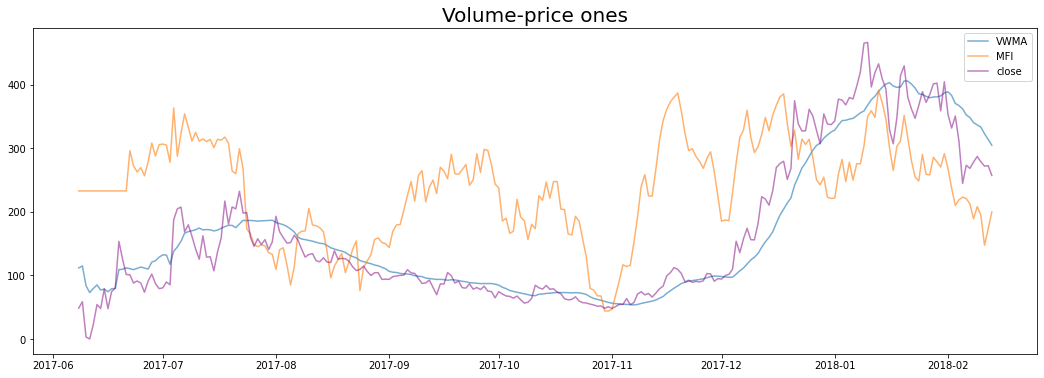

In [ ]:
plt.figure(figsize=(18,6))
plt.title('Volume-price ones', fontsize=20)
x = pd.to_datetime(veri.index)
plt.plot(x, veri['vwma'], label='VWMA', alpha=0.6)

plt.plot(x, veri['mfi']*466, label='MFI', alpha=0.6)

plt.plot(x, veri['close'], label='close', alpha=0.5, color='purple')

plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

**Вывод:**
- совсем разные

### Crosses

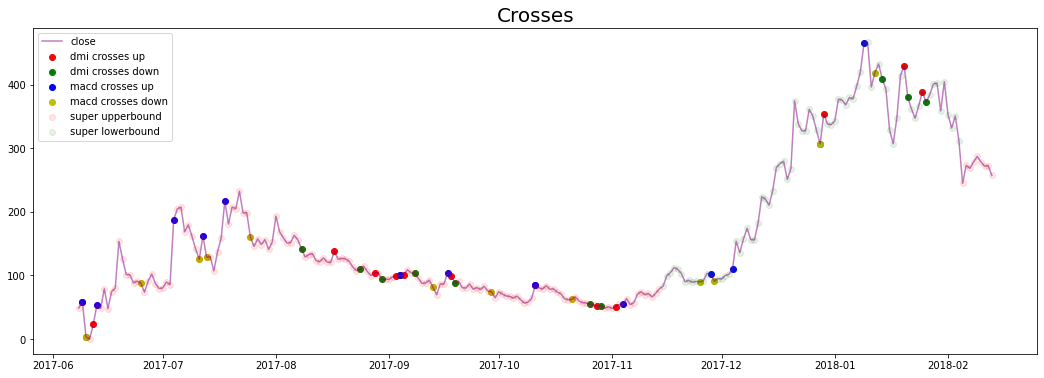

In [ ]:
plt.figure(figsize=(18,6))
plt.title('Crosses', fontsize=20)
x = pd.to_datetime(veri.index)
dmi_crosses_up = veri['close'].copy()
dmi_crosses_down = veri['close'].copy()
dmi_crosses_up[veri['pdi_xu_mdi'] == False] = None
dmi_crosses_down[veri['pdi_xd_mdi'] == False] = None
plt.scatter(x, dmi_crosses_up, label='dmi crosses up', alpha=1, color='r')
plt.scatter(x, dmi_crosses_down, label='dmi crosses down', alpha=1, color='g')

macd_crosses_up = veri['close'].copy()
macd_crosses_down = veri['close'].copy()
macd_crosses_up[veri['macd_xu_macds'] == False] = None
macd_crosses_down[veri['macd_xd_macds'] == False] = None
plt.scatter(x, macd_crosses_up, label='macd crosses up', alpha=1, color='b')
plt.scatter(x, macd_crosses_down, label='macd crosses down', alpha=1, color='y')

super_crosses_up = veri['close'].copy()
super_crosses_down = veri['close'].copy()
super_crosses_up[veri['supertrend'] != veri['supertrend_ub']] = None
super_crosses_down[veri['supertrend'] != veri['supertrend_lb']] = None
plt.scatter(x, super_crosses_up, label='super upperbound', alpha=0.1, color='r')
plt.scatter(x, super_crosses_down, label='super lowerbound', alpha=0.1, color='g')

plt.plot(x, veri['close'], label='close', alpha=0.5, color='purple')
plt.legend()
# plt.xlim((pd.to_datetime('2017-09-01'), pd.to_datetime('2017-11-30')))
plt.show()

## **Итог**
```
- Close:         RSI, PPO, TEMA or KAMA, MACDhist
- Volatility:    ATR, BollUb-BollLb
- Crazy:         StochRSI, WR or KDJ-J
- Middle:        WT1/2, CCI, CR, CHOP
- Volume(price): VWMA, MFI, VR

- Crosses:       DMI, MACD, SuperTrend, Boll
- Как-то:        KDJ
```

